## Fit exponential decays to dwelltime data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
from lmfit import Minimizer, Parameter, Parameters
from exponential_distributions_renorm import exp1_dist, exp2_dist, exp3_dist, exp4_dist, LogLike, log_bin

from IPython.display import display, clear_output
from ipywidgets import Checkbox, Button, HBox, VBox, Layout, Output

from inspect import signature
import time
import concurrent.futures

In [3]:
pd.options.display.max_columns = 100

In [4]:
df1 = pd.read_csv('all_dwelltime_data.csv')

In [143]:
df1.groupby('DNA')['offtime'].count()

DNA
DNA00     376
DNA01     222
DNA02     334
DNA03     423
DNA04     793
DNA05    1362
DNA06     514
DNA07     660
DNA08    2405
DNA09    1248
DNA10    2097
DNA11     957
DNA12     816
DNA13     530
DNA14     276
DNA15     311
DNA16     321
DNA17     387
DNA18    1931
DNA19     127
DNA20     713
Name: offtime, dtype: int64

In [34]:
def fit_exp(dwell_data, model, objective, name='exp_fit', Tmin=0, Tmax=np.inf, method='dual_annealing'):
    
    n_exp = (len(signature(model).parameters) - 3) / 2
    n_exp = int(n_exp)
    # add the parameters
    params = Parameters()
    for i in range(n_exp):
        
        if i < n_exp - 1:
            params.add(f'p{i + 1}', value=0.9/n_exp,  min=1e-6, max=1)
        else:
            params.add(f'p{i + 1}')
            
    for i in range(n_exp):
        # add the taus    
        params.add(f'tau{i + 1}', value=np.quantile(dwell_data, 1/(n_exp - i)), min=0.1, max=2*dwell_data.max())
        
    params.add('Tmin', value=Tmin, vary=False)
    params.add('Tmax', value=Tmax, vary=False)
    
    # set the expression for the last p which is constrained
    cons = [f'-p{i+1}' for i in range(n_exp - 1)]
    express = '1' + ''.join(cons)
    params[f'p{i + 1}'].set(expr=express)
    mini =  Minimizer(objective, params, fcn_args=(model, dwell_data))
    result = mini.minimize(method='dual_annealing')
    
#     # Put the result in a pandas dataframe
    df_ress = pd.json_normalize(result.__dict__)[['nfev', 'nvarys', 'success', 'da_fun', 'residual', 
                                          'chisqr', 'redchi', 'aic', 'bic', 'call_kws.maxiter', 'call_kws.initial_temp', 
                                          'call_kws.restart_temp_ratio', 'call_kws.visit', 'call_kws.accept', 'call_kws.maxfun',
                                          'call_kws.no_local_search']]
    
    df_pars = pd.DataFrame(result.__dict__['params'].valuesdict(), index=[0])
    # sort parameters for taus to be in ascending order
    row=df_pars.values
    p = row[:, :(row.shape[1]-2)//2].flatten() # separate p's
    tau = row[:, (row.shape[1]-2)//2:-2].flatten() # separate taus
    inds = tau.argsort() # find sorted indices of taus
    pars_sorted = np.concatenate([p[inds], tau[inds], row[:, -2:].flatten()]) # concat p's and taus and add back Tmin and Tmain frozen params
    df_pars.iloc[0] = pars_sorted
    
    df_name = pd.DataFrame({'name': name}, index=[0])
    df_popt = pd.DataFrame({'popt': str(list(result.params.valuesdict().values()))}, index=[0])
    df_r = pd.concat([df_name, df_pars, df_popt, df_ress], axis=1)
    
    return result, df_r
    

In [35]:
df1.head()

,mol_nr,event_order,time,color,state,method,thres,kon,Iroff,Igoff,Imin,isSelected,offtime,side,ontime,onside,order,avrgFRET,DNA,date,exposure,path,hel
0,1,0,0.000000,red,1,thres,50.0,0,0,0,0,0,4.300000,l,394.800000,r,0.0,0.85,DNA04,20200812,0.1,H:\SM-data\good\20200812_WTcas9_DNA04-07-10-20...,hel1
1,2,0,0.000000,red,1,man,NaN,0,0,0,0,0,34.250599,l,15.616233,m,0.0,0.81,DNA04,20200812,0.1,H:\SM-data\good\20200812_WTcas9_DNA04-07-10-20...,hel1
2,2,1,49.866832,red,1,man,NaN,0,0,0,0,0,0.314210,m,53.778352,m,1.0,0.81,DNA04,20200812,0.1,H:\SM-data\good\20200812_WTcas9_DNA04-07-10-20...,hel1
3,2,2,103.959394,red,1,man,NaN,0,0,0,0,0,40.430488,m,254.710119,r,2.0,0.81,DNA04,20200812,0.1,H:\SM-data\good\20200812_WTcas9_DNA04-07-10-20...,hel1
4,5,0,0.000000,red,1,man,NaN,0,0,0,0,0,29.149798,l,369.950202,r,0.0,0.83,DNA04,20200812,0.1,H:\SM-data\good\20200812_WTcas9_DNA04-07-10-20...,hel1


In [36]:
Tmin = 0.2
Tmax = 600
df = df1[(df1.offtime > Tmin) 
         & (df1.offtime < Tmax) 
         & (df1.side == 'm') 
        ]

In [37]:
dna_dat = df.query('DNA == "DNA05"')

In [38]:
data = dna_dat.offtime.values

In [39]:
res, df_res = fit_exp(data, exp3_dist, LogLike, Tmin=Tmin, Tmax=Tmax)
print(lmfit.fit_report(res))

[[Fit Statistics]]
    # fitting method   = dual_annealing
    # function evals   = 11171
    # data points      = 1
    # variables        = 5
    chi-square         = 8966730.25
    reduced chi-square = 8966730.25
    Akaike info crit   = 26.0090316
    Bayesian info crit = 16.0090316
##  Warning: uncertainties could not be estimated:
[[Variables]]
    p1:    0.08005143 (init = 0.3)
    p2:    0.50324614 (init = 0.3)
    p3:    0.41670243 == '1-p1-p2'
    tau1:  70.7525352 (init = 0.7698426)
    tau2:  4.74340552 (init = 1.54516)
    tau3:  0.52296684 (init = 582.1488)
    Tmin:  0.2 (fixed)
    Tmax:  600 (fixed)


In [40]:
df_res

,name,p1,p2,p3,tau1,tau2,tau3,Tmin,Tmax,popt,nfev,nvarys,success,da_fun,residual,chisqr,redchi,aic,bic,call_kws.maxiter,call_kws.initial_temp,call_kws.restart_temp_ratio,call_kws.visit,call_kws.accept,call_kws.maxfun,call_kws.no_local_search
0,exp_fit,0.416702,0.503246,0.080051,0.522967,4.743406,70.752535,0.2,600,"[0.08005142726264029, 0.5032461406969988, 0.41...",11171,5,True,[2994.4499081228005],[2994.4499081228005],8.966730e+06,8.966730e+06,26.009032,16.009032,1000,5230.0,0.00002,2.62,-5.0,2400000,False


In [124]:
def plot_fitted_hist(popt, dwelltimes, model, name='exp. fit', bin_width=0.1, axis=None):
    if axis is None:
        plt.figure(figsize=(10, 8))
        axis = plt.gca()
    cent, val = log_bin(dwelltimes, bin_width=bin_width)
    axis.plot(cent, val, 'o')
    axis.plot(cent, model(cent, *popt), label=name)

    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlim(0.1, 5000)
    axis.set_ylim(1e-7, 10)
    axis.legend()

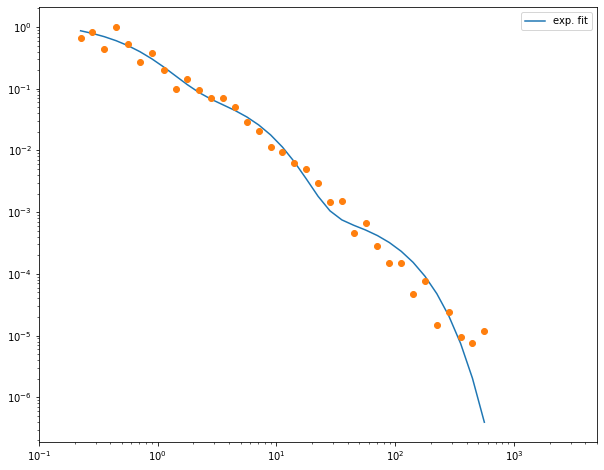

In [82]:
popt = list(res.params.valuesdict().values())
plot_fitted_hist(popt, exp3_dist)

### We can now fit all the DNA constructs with a loop

In [89]:
# apply filters on data
Tmin = 0.2
Tmax = 100000
df = df1[(df1.offtime > Tmin) 
         & (df1.offtime < Tmax) 
         & (df1.side == 'm')
        ] 
         # & (df1.exposure != 0.1)]

In [97]:
models = [exp2_dist, exp3_dist, exp4_dist]
results = []

all_fits = []

for i in range(1):
    start_loop = time.time()
    for model in models:
        model_lst = []
        for d in np.sort(df.DNA.unique()):
            start = time.time()
            dwells = df.query('DNA == @d').offtime.values
            re, df_res = fit_exp(dwells, model, LogLike, name=d, Tmin=Tmin, Tmax=Tmax)
            results.append(re)
            model_lst.append(df_res)
            stop = time.time()
            # print(f'{d} fitted in {stop - start:.1f} s')
        df_model = pd.concat(model_lst).sort_values(by='name').reset_index(drop=True)

        all_fits.append(df_model)
    stop_loop = time.time()
    print(f'Loop {i} fitting time: {stop_loop - start_loop:.1f}')


Loop 0 fitting time: 198.2


In [134]:
# collect all bic values for each model
bics = []        
for fit in all_fits:
    bics.append(fit.bic)
df_bics = pd.concat(bics, axis=1)

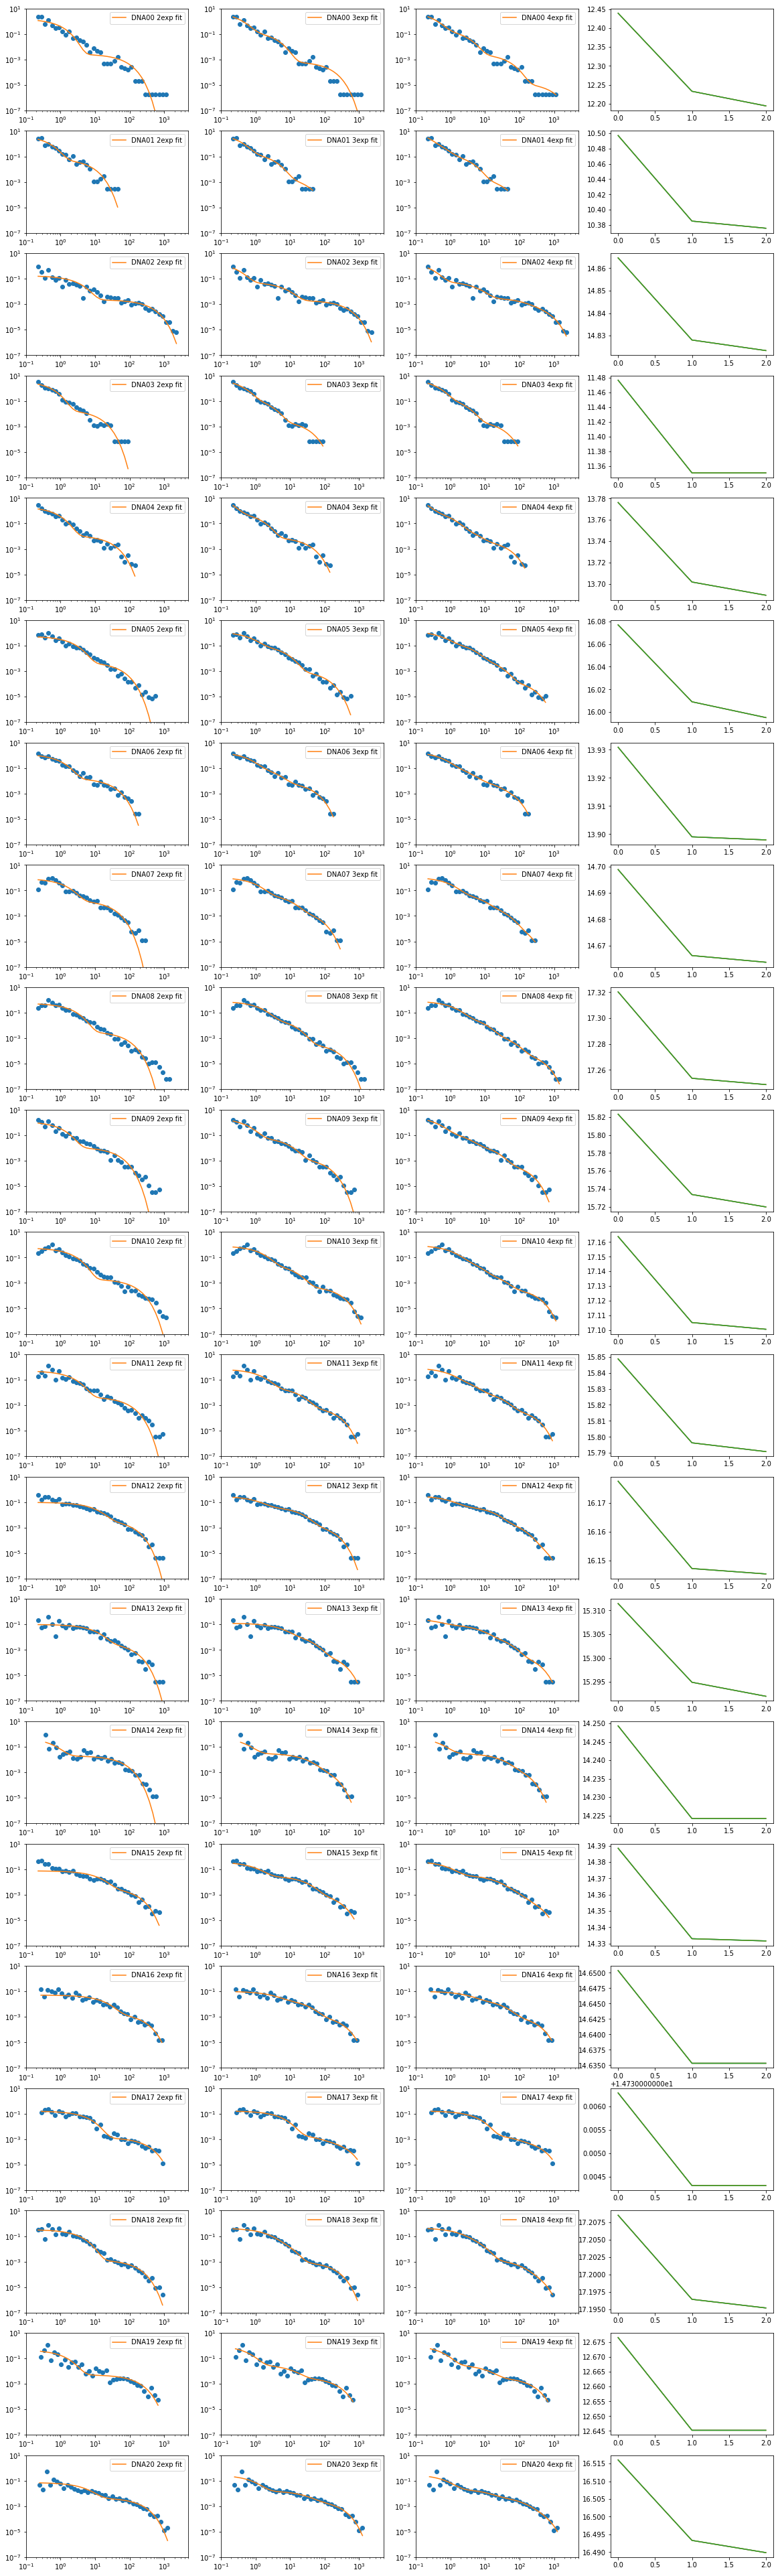

In [140]:
fig, axes = plt.subplots(nrows=21, ncols=4, figsize=(20, 70))
# plot 2exp fits
for j, mod in enumerate([exp2_dist, exp3_dist, exp4_dist]):
    
    for i, poptima in enumerate(all_fits[j].popt):

        ax = axes[i, j]
        d = all_fits[j].name[i]
        dwells = df.query('DNA == @d').offtime.values
        name = d + f' {j+2}exp fit'
        # print(name)
        plot_fitted_hist(eval(poptima), dwells, mod, name=name, axis=ax)
        axes[i, -1].plot(df_bics.iloc[i, :].values)

        


In [142]:
fig.savefig('allfits.png', dpi=300, facecolor='white')

In [128]:
all

[0     12.439551
 1     10.497019
 2     14.864578
 3     11.476624
 4     13.776157
 5     16.076953
 6     13.930856
 7     14.698798
 8     17.320266
 9     15.823341
 10    17.163734
 11    15.848700
 12    16.177431
 13    15.311422
 14    14.249310
 15    14.388396
 16    14.650340
 17    14.736286
 18    17.208468
 19    12.676492
 20    16.516014
 Name: bic, dtype: float64,
 0     12.232647
 1     10.385050
 2     14.828077
 3     11.351046
 4     13.701610
 5     16.009046
 6     13.899036
 7     14.666260
 8     17.253546
 9     15.733563
 10    17.105094
 11    15.796255
 12    16.147233
 13    15.294929
 14    14.224150
 15    14.332957
 16    14.635312
 17    14.734313
 18    17.196434
 19    12.645238
 20    16.493319
 Name: bic, dtype: float64,
 0     12.193987
 1     10.375723
 2     14.823384
 3     11.351033
 4     13.689217
 5     15.995106
 6     13.897940
 7     14.663731
 8     17.248697
 9     15.719681
 10    17.100519
 11    15.790788
 12    16.145369
 13    15

In [ ]:
taus = df_fitted.loc[:, ['name', 'tau1','tau2', 'tau3']]
taus_melt = taus.melt(id_vars='name', var_name='component', value_name='tau')

plt.figure(figsize=(12,6 ))
sns.lineplot(data=taus_melt, x='name', y='tau', hue='component')
plt.xticks(rotation=90)
plt.savefig('taus_dna_renorm.png', dpi=200, facecolor='white')
None

NameError: name 'df_fitted' is not defined

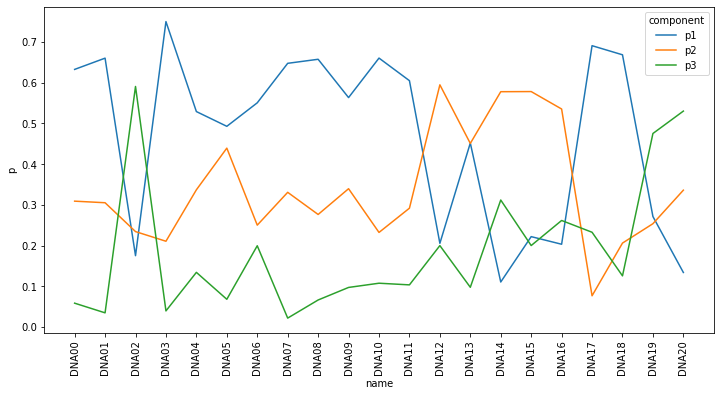

In [17]:
ps = df_fitted.loc[:, ['name', 'p1','p2', 'p3']]
p_melt = ps.melt(id_vars='name', var_name='component', value_name='p')

plt.figure(figsize=(12,6 ))
sns.lineplot(data=p_melt, x='name', y='p', hue='component')
plt.xticks(rotation=90)
plt.savefig('p_dna_renorm.png', dpi=200, facecolor='white')
None

In [18]:
df_melted = pd.concat([taus_melt, p_melt], axis=1).iloc[:, [0, 1, 2, 5]]

In [199]:
df_melted.head(2)

,name,component,tau,p
0,DNA00,tau1,0.214442,0.499232
1,DNA01,tau1,0.219963,0.561407


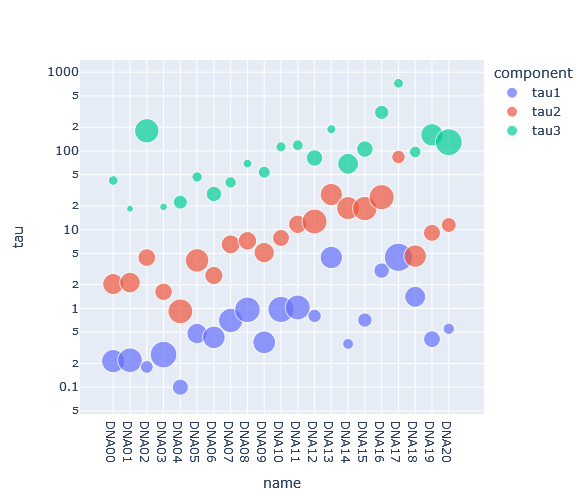

In [200]:
import plotly.express as px

fig = px.scatter(df_melted, x="name", y="tau",
	         size="p", color="component", height=500, log_y=True
                 )
fig.show()

In [118]:
fig.write_html("bubble_chart_renorm.html")